In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [2]:
RANDOM_STATE = 42
df = pd.read_excel('ap_pro_data.xls', 'Physicians - Discretized', skiprows=2)
df.head()

,VisitID,RecordID,Age,Sex,PainDur,PainSite,PainType,Vomiting,PrevVis,Temp,TendSite,Guard,RebTend,PainShift,WBC,Triage,Observer
0,1,1,ge5y,female,gt24h_le7d,lower_abdomen,constant,yes,no,ge37_le39,lower_abdomen,no,no,no,?,discharge,discharge
1,2,2,lt5y,female,gt24h_le7d,lower_abdomen,intermittent,no,no,lt37,other,no,no,no,?,discharge,discharge
2,3,3,ge5y,male,le24h,lower_abdomen,constant,no,no,lt37,lower_abdomen,no,yes,no,ge12,consult,observation
3,4,4,ge5y,female,le24h,other,constant,no,yes,ge37_le39,other,no,no,no,ge12,discharge,discharge
4,5,5,lt5y,female,le24h,other,intermittent,yes,no,ge37_le39,other,no,no,no,?,discharge,observation


In [3]:
df.describe(include='all')

,VisitID,RecordID,Age,Sex,PainDur,PainSite,PainType,Vomiting,PrevVis,Temp,TendSite,Guard,RebTend,PainShift,WBC,Triage,Observer
count,457.000000,457.000000,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457
unique,NaN,NaN,2,2,4,3,3,3,3,4,4,3,3,3,4,3,3
top,NaN,NaN,ge5y,female,le24h,other,intermittent,no,no,lt37,other,no,no,no,?,discharge,discharge
freq,NaN,NaN,369,237,275,276,281,265,437,276,230,385,404,371,354,348,265
mean,229.000000,229.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,132.068795,132.068795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,115.000000,115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,229.000000,229.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,343.000000,343.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['WBC'].value_counts()

WBC
?           354
gt4_lt12     58
ge12         42
le4           3
Name: count, dtype: int64

## Binaryzacja klas

Klasy 'discharge' oraz 'observation' zostały zmapowane na klasę negatywną, natomiast klasa 'consult' została zmapowana na klasę pozytywną

In [5]:
df = df.drop(['VisitID', 'RecordID', 'Observer', 'WBC'], axis=1)
mapper = {'discharge': 0, 'observation': 0, 'consult': 1}
df['Triage'] = df['Triage'].map(mapper)
df = pd.get_dummies(df)
df.head()

,Triage,Age_ge5y,Age_lt5y,Sex_female,Sex_male,PainDur_?,PainDur_gt24h_le7d,PainDur_gt7d,PainDur_le24h,PainSite_RLQ,...,TendSite_other,Guard_?,Guard_no,Guard_yes,RebTend_?,RebTend_no,RebTend_yes,PainShift_?,PainShift_no,PainShift_yes
0,0,True,False,True,False,False,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
1,0,False,True,True,False,False,True,False,False,False,...,True,False,True,False,False,True,False,False,True,False
2,1,True,False,False,True,False,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
3,0,True,False,True,False,False,False,False,True,False,...,True,False,True,False,False,True,False,False,True,False
4,0,False,True,True,False,False,False,False,True,False,...,True,False,True,False,False,True,False,False,True,False


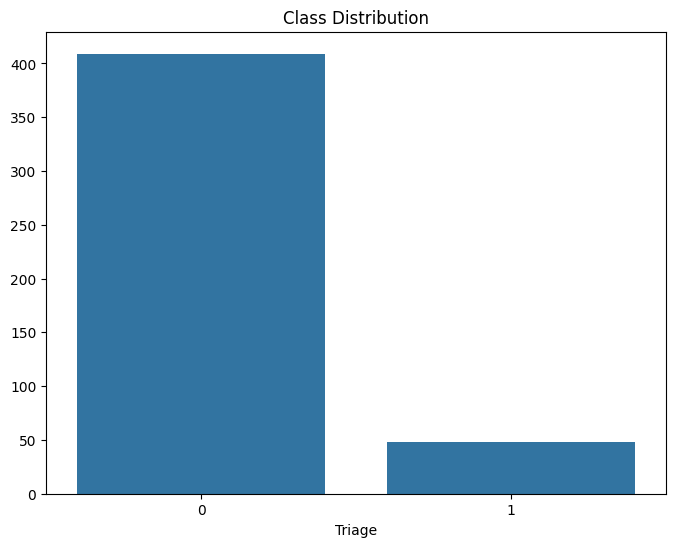

In [6]:
# Class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=df['Triage'].value_counts().index, y=df['Triage'].value_counts().values)
plt.title('Class Distribution')
plt.show()

## Klasyfikator bazowy

Jako klasyfikator bazowy przyjąłem regresję logistyczną

In [7]:
baseline_clf = LogisticRegression(random_state=RANDOM_STATE)
baseline_clf.fit(df.drop('Triage', axis=1), df['Triage'])

LogisticRegression(random_state=42)

Processing fold 1 of 25
Processing fold 2 of 25
Processing fold 3 of 25
Processing fold 4 of 25
Processing fold 5 of 25
Processing fold 6 of 25
Processing fold 7 of 25
Processing fold 8 of 25
Processing fold 9 of 25
Processing fold 10 of 25
Processing fold 11 of 25
Processing fold 12 of 25
Processing fold 13 of 25
Processing fold 14 of 25
Processing fold 15 of 25
Processing fold 16 of 25
Processing fold 17 of 25
Processing fold 18 of 25
Processing fold 19 of 25
Processing fold 20 of 25
Processing fold 21 of 25
Processing fold 22 of 25
Processing fold 23 of 25
Processing fold 24 of 25
Processing fold 25 of 25

===== RESULTS =====

BASELINE CLASSIFIER:
AUPRC: 0.6527 (±0.1424)
AUROC: 0.9107 (±0.0661)

Medium-risk threshold (neg < threshold):
FNR: 0.2000 (±0.4000)
FPR: 0.0000 (±0.0000)
% classified as negative: 17.95%

High-risk threshold (pos >= threshold):
FNR: 0.0000 (±0.0000)
FPR: 1.0000 (±0.0000)
% classified as positive: 16.67%
Gray zone (moderate risk): 65.38%

TARGET CLASSIFIER:
AU

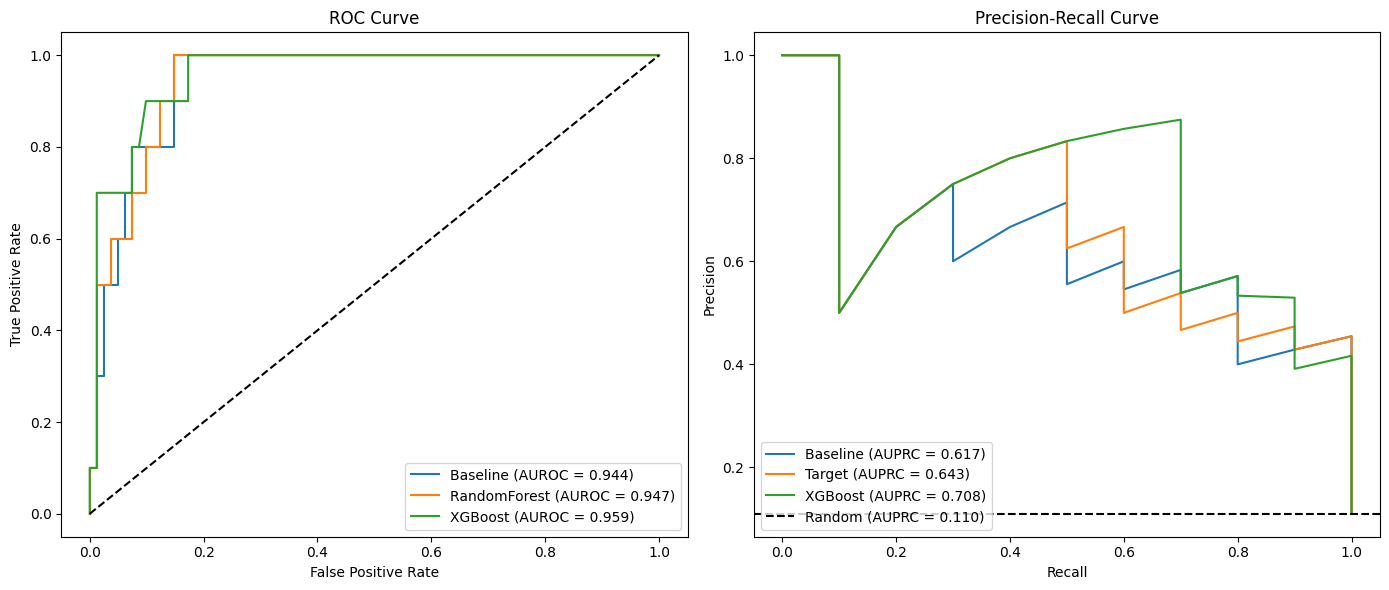

In [9]:
X = df.drop('Triage', axis=1).values
y = df['Triage'].values

# Keep your existing RandomForest pipeline
target_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# RandomForest hyperparameters for grid search
target_param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 6, 9],
    'clf__min_samples_split': [2, 4],
    'clf__min_samples_leaf': [1, 2]
}

target_clf = GridSearchCV(
    target_pipeline,
    target_param_grid,
    cv=3,
    scoring='average_precision',
    n_jobs=-1
)

# Add XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
])

# XGBoost hyperparameters for grid search
xgb_param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 6, 9],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__scale_pos_weight': [1, 5]  # For class imbalance
}

xgb_clf = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    scoring='average_precision',
    n_jobs=-1
)

# Update results dictionary to include XGBoost
results = {
    'baseline': {
        'auroc': [], 'auprc': [],
        'med_fnr': [], 'med_fpr': [], 'med_pct': [],
        'high_fnr': [], 'high_fpr': [], 'high_pct': [],
    },
    'target': {
        'auroc': [], 'auprc': [],
        'med_fnr': [], 'med_fpr': [], 'med_pct': [],
        'high_fnr': [], 'high_fpr': [], 'high_pct': [],
    },
    'xgboost': {
        'auroc': [], 'auprc': [],
        'med_fnr': [], 'med_fpr': [], 'med_pct': [],
        'high_fnr': [], 'high_fpr': [], 'high_pct': [],
    }
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

# Update training and evaluation loop
fold_count = 0
for train_idx, test_idx in cv.split(X, y):
    fold_count += 1
    print(f"Processing fold {fold_count} of {cv.get_n_splits()}")
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train all classifiers
    baseline_clf.fit(X_train, y_train)
    target_clf.fit(X_train, y_train)
    xgb_clf.fit(X_train, y_train)
    
    # For all classifiers
    for clf_name, clf in [('baseline', baseline_clf), ('target', target_clf), ('xgboost', xgb_clf)]:
        # The rest of your evaluation code stays the same
        # Get predicted probabilities
        y_proba = clf.predict_proba(X_test)[:, 1]
        
        # A) Calculate AUROC and AUPRC
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
        
        auroc = auc(fpr, tpr)
        auprc = auc(recall, precision)
        
        results[clf_name]['auroc'].append(auroc)
        results[clf_name]['auprc'].append(auprc)
        
        # B) Determine thresholds on training data
        train_proba = clf.predict_proba(X_train)[:, 1]
        train_precision, train_recall, train_pr_thresholds = precision_recall_curve(y_train, train_proba)
        train_fpr, train_tpr, train_roc_thresholds = roc_curve(y_train, train_proba)
        
        # i) Medium-risk threshold: sensitivity >= 99%
        # Sensitivity = Recall = TPR
        sensitivity_99_idx = np.where(train_tpr >= 0.99)[0][0]  # First index where sensitivity >= 99%
        medium_risk_threshold = train_roc_thresholds[sensitivity_99_idx]
        
        # ii) High-risk threshold: specificity >= 90%
        # Specificity = 1 - FPR
        specificity_90_idx = np.where(1 - train_fpr >= 0.90)[0][-1]  # Last index where specificity >= 90%
        high_risk_threshold = train_roc_thresholds[specificity_90_idx]
        
        # C) Apply thresholds to classify test data
        y_pred_medium = np.where(y_proba < medium_risk_threshold, 0, -1)  # Negative or unclassified
        y_pred_high = np.where(y_proba >= high_risk_threshold, 1, -1)     # Positive or unclassified
        
        # Combine predictions: negative < medium_threshold, positive >= high_threshold, else gray
        y_pred_combined = np.copy(y_pred_medium)
        high_mask = y_pred_high == 1
        y_pred_combined[high_mask] = 1
        
        # D) Calculate metrics
        # For medium-risk threshold (detecting negatives)
        medium_mask = y_pred_medium != -1
        if medium_mask.sum() > 0:
            # FNR: False Negative Rate among examples classified as negative
            fn_medium = np.sum((y_pred_medium == 0) & (y_test == 1))
            actual_pos_medium = np.sum(y_test[medium_mask] == 1)
            med_fnr = fn_medium / actual_pos_medium if actual_pos_medium > 0 else 0
            
            # FPR: False Positive Rate among examples classified as negative
            fp_medium = np.sum((y_pred_medium == 1) & (y_test == 0))
            actual_neg_medium = np.sum(y_test[medium_mask] == 0)
            med_fpr = fp_medium / actual_neg_medium if actual_neg_medium > 0 else 0
            
            # Percentage classified as negative
            med_pct = np.mean(y_pred_medium == 0)
        else:
            med_fnr, med_fpr, med_pct = 0, 0, 0
            
        # For high-risk threshold (detecting positives)
        high_mask = y_pred_high != -1
        if high_mask.sum() > 0:
            # FNR: False Negative Rate among examples classified as positive
            fn_high = np.sum((y_pred_high == 0) & (y_test == 1))
            actual_pos_high = np.sum(y_test[high_mask] == 1)
            high_fnr = fn_high / actual_pos_high if actual_pos_high > 0 else 0
            
            # FPR: False Positive Rate among examples classified as positive
            fp_high = np.sum((y_pred_high == 1) & (y_test == 0))
            actual_neg_high = np.sum(y_test[high_mask] == 0)
            high_fpr = fp_high / actual_neg_high if actual_neg_high > 0 else 0
            
            # Percentage classified as positive
            high_pct = np.mean(y_pred_high == 1)
        else:
            high_fnr, high_fpr, high_pct = 0, 0, 0
        
        # Store results
        results[clf_name]['med_fnr'].append(med_fnr)
        results[clf_name]['med_fpr'].append(med_fpr)
        results[clf_name]['med_pct'].append(med_pct)
        results[clf_name]['high_fnr'].append(high_fnr)
        results[clf_name]['high_fpr'].append(high_fpr)
        results[clf_name]['high_pct'].append(high_pct)

# Step 5: Calculate and display averages
print("\n===== RESULTS =====")
for clf_name in ['baseline', 'target', 'xgboost']:
    print(f"\n{clf_name.upper()} CLASSIFIER:")
    print(f"AUPRC: {np.mean(results[clf_name]['auprc']):.4f} (±{np.std(results[clf_name]['auprc']):.4f})")
    print(f"AUROC: {np.mean(results[clf_name]['auroc']):.4f} (±{np.std(results[clf_name]['auroc']):.4f})")
    
    print("\nMedium-risk threshold (neg < threshold):")
    print(f"FNR: {np.mean(results[clf_name]['med_fnr']):.4f} (±{np.std(results[clf_name]['med_fnr']):.4f})")
    print(f"FPR: {np.mean(results[clf_name]['med_fpr']):.4f} (±{np.std(results[clf_name]['med_fpr']):.4f})")
    print(f"% classified as negative: {np.mean(results[clf_name]['med_pct'])*100:.2f}%")
    
    print("\nHigh-risk threshold (pos >= threshold):")
    print(f"FNR: {np.mean(results[clf_name]['high_fnr']):.4f} (±{np.std(results[clf_name]['high_fnr']):.4f})")
    print(f"FPR: {np.mean(results[clf_name]['high_fpr']):.4f} (±{np.std(results[clf_name]['high_fpr']):.4f})")
    print(f"% classified as positive: {np.mean(results[clf_name]['high_pct'])*100:.2f}%")
    
    # Calculate gray zone percentage
    gray_zone_pct = 100 - (np.mean(results[clf_name]['med_pct'])*100 + np.mean(results[clf_name]['high_pct'])*100)
    print(f"Gray zone (moderate risk): {gray_zone_pct:.2f}%")

# Visualize PR and ROC curves for the final fold
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
for clf_name, clf in [('Baseline', baseline_clf), ('RandomForest', target_clf), ('XGBoost', xgb_clf)]:
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{clf_name} (AUROC = {roc_auc:.3f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for clf_name, clf in [('Baseline', baseline_clf), ('Target', target_clf), ('XGBoost', xgb_clf)]:
    y_proba = clf.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{clf_name} (AUPRC = {pr_auc:.3f})')
    
plt.axhline(y=np.mean(y_test), color='k', linestyle='--', 
           label=f'Random (AUPRC = {np.mean(y_test):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()